In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/archive.zip'

extract_to_path = '/content/traffic_light'

os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"zip to: {extract_to_path}")

zip to: /content/traffic_light


In [3]:
import random
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision import transforms


In [26]:
# !pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 23.8 MB/s eta 0:00:00


In [39]:
import os
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from ultralytics import YOLO
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [ ]:
# 数据集定义
class TrafficLightDataset(Dataset):
    def __init__(self, json_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.load_annotations(json_file)

    def load_annotations(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        return data['annotations']

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_dir, annotation['filename']).replace("\\", "/")
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Invalid image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        bbox = annotation['bndbox']
        bbox = torch.tensor([bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']], dtype=torch.float32)

        color = 0  # 默认红灯
        if annotation['inbox']:
            color = 1 if annotation['inbox'][0]['color'] == 'green' else 0
        color = torch.tensor(color, dtype=torch.long)

        return image, bbox, color


# 数据预处理
def get_data_loaders(json_file, image_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = TrafficLightDataset(json_file, image_dir, transform=transform)
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader



class MobileNetTrafficLightModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetTrafficLightModel, self).__init__()
        self.base_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        for param in self.base_model.features[:-5].parameters():
            param.requires_grad = False

        self.shared_layer = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.bbox_head = nn.Linear(128, 4)
        self.color_head = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = x.mean([2, 3])  # Global Average Pooling
        x = self.shared_layer(x)
        bbox = self.bbox_head(x)
        color = self.color_head(x)
        return bbox, color


# 训练函数
def train_model(model, train_loader, val_loader, epochs=30, lr=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion_bbox = nn.SmoothL1Loss()
    criterion_color = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, bboxes, colors in train_loader:
            images, bboxes, colors = images.to(device), bboxes.to(device), colors.to(device)
            optimizer.zero_grad()
            pred_bboxes, pred_colors = model(images)
            loss_bbox = criterion_bbox(pred_bboxes, bboxes)
            loss_color = criterion_color(pred_colors, colors)
            loss = loss_bbox + loss_color
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, bboxes, colors in val_loader:
                images, bboxes, colors = images.to(device), bboxes.to(device), colors.to(device)
                pred_bboxes, pred_colors = model(images)
                loss_bbox = criterion_bbox(pred_bboxes, bboxes)
                loss_color = criterion_color(pred_colors, colors)
                loss = loss_bbox + loss_color
                val_loss += loss.item()

        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


# 测试函数
def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    criterion_bbox = nn.SmoothL1Loss()
    criterion_color = nn.CrossEntropyLoss()
    test_loss = 0
    with torch.no_grad():
        for images, bboxes, colors in test_loader:
            images, bboxes, colors = images.to(device), bboxes.to(device), colors.to(device)
            pred_bboxes, pred_colors = model(images)
            loss_bbox = criterion_bbox(pred_bboxes, bboxes)
            loss_color = criterion_color(pred_colors, colors)
            loss = loss_bbox + loss_color
            test_loss += loss.item()

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")


if __name__ == "__main__":
    json_file_path = "/content/traffic_light/train_dataset/train.json"
    image_dir = "/content/traffic_light/train_dataset"
    train_loader, val_loader, test_loader = get_data_loaders(json_file_path, image_dir, batch_size=32)
    model = MobileNetTrafficLightModel(num_classes=2)
    train_model(model, train_loader, val_loader, epochs=30, lr=1e-4)
    test_model(model, test_loader)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 73.6MB/s]


Epoch 1/30, Train Loss: 759.9927, Val Loss: 311.3528


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

def evaluate_model(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model = model.to(device)

    all_true_colors = []
    all_pred_colors = []
    all_iou_scores = []

    with torch.no_grad():
        for images, true_bboxes, true_colors in data_loader:
            images, true_bboxes, true_colors = images.to(device), true_bboxes.to(device), true_colors.to(device)

            # 模型预测
            pred_bboxes, pred_colors = model(images)
            pred_colors = (pred_colors.squeeze() > 0.5).long()  # 阈值为 0.5

            # 保存真实值和预测值用于分类评估
            all_true_colors.extend(true_colors.cpu().numpy())
            all_pred_colors.extend(pred_colors.cpu().numpy())

            # 计算 IoU
            for true_bbox, pred_bbox in zip(true_bboxes, pred_bboxes):
                iou = calculate_iou(true_bbox.cpu().numpy(), pred_bbox.cpu().numpy())
                all_iou_scores.append(iou)

    # 分类指标
    accuracy = accuracy_score(all_true_colors, all_pred_colors)
    precision = precision_score(all_true_colors, all_pred_colors)
    recall = recall_score(all_true_colors, all_pred_colors)
    f1 = f1_score(all_true_colors, all_pred_colors)

    # 回归指标
    mean_iou = sum(all_iou_scores) / len(all_iou_scores)

    print("Classification Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nRegression Metrics:")
    print(f"Mean IoU: {mean_iou:.4f}")

def calculate_iou(true_bbox, pred_bbox):
    """计算 IoU（Intersection over Union）"""
    x1 = max(true_bbox[0], pred_bbox[0])
    y1 = max(true_bbox[1], pred_bbox[1])
    x2 = min(true_bbox[2], pred_bbox[2])
    y2 = min(true_bbox[3], pred_bbox[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    true_area = (true_bbox[2] - true_bbox[0]) * (true_bbox[3] - true_bbox[1])
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    union = true_area + pred_area - intersection

    return intersection / union if union > 0 else 0

# 评估模型
evaluate_model(model, val_loader)


Classification Metrics:
Accuracy: 0.7651
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Regression Metrics:
Mean IoU: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


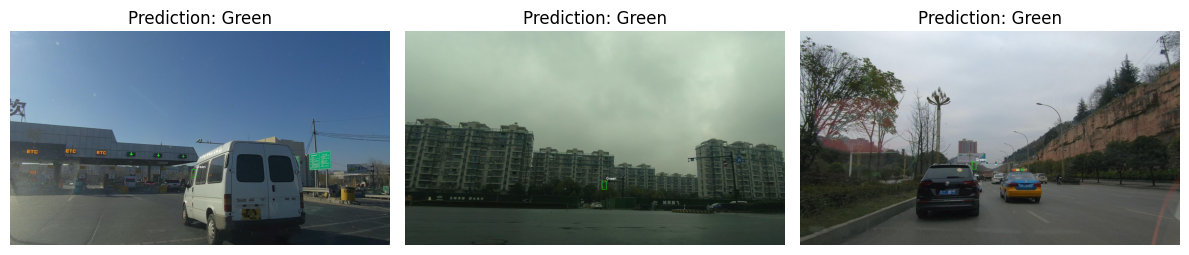

In [35]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0)  # 添加批量维度
    return image

def get_random_samples(image_dir, num_samples=3):
    images = os.listdir(image_dir)
    random_samples = random.sample(images, num_samples)
    return [os.path.join(image_dir, img) for img in random_samples]

def predict_and_display(model, image_paths):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()  # 设置为评估模式

    plt.figure(figsize=(12, 8))
    for idx, image_path in enumerate(image_paths):
        image = preprocess_image(image_path).to(device)

        with torch.no_grad():
            bbox, color = model(image)
            bbox = bbox.squeeze().cpu().numpy()
            color = torch.sigmoid(color).item()

        # 读取原始图像
        orig_image = cv2.imread(image_path)
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

        # 绘制边界框
        xmin, ymin, xmax, ymax = map(int, bbox)
        label = "Green" if color > 0.5 else "Red"
        cv2.rectangle(orig_image, (xmin, ymin), (xmax, ymax), (0, 255, 0) if label == "Green" else (255, 0, 0), 2)
        cv2.putText(orig_image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        # 显示结果
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(orig_image)
        plt.title(f"Prediction: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 模型路径
    image_dir = "/content/traffic_light/train_dataset/train_images"  # 替换为训练图像的实际路径

    # 直接使用之前训练的 model
    # 随机选择3张图片
    random_samples = get_random_samples(image_dir, num_samples=3)

    # 预测并展示结果
    predict_and_display(model, random_samples)


In [28]:
torch.save(model.state_dict(), "traffic_light_model_weights.pth")
torch.save(model, "traffic_light_model.pth")


In [23]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, num_samples=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model = model.to(device)

    samples_shown = 0
    plt.figure(figsize=(15, num_samples * 5))

    with torch.no_grad():
        for images, true_bboxes, true_colors in data_loader:
            images = images.to(device)
            true_bboxes = true_bboxes.cpu().numpy()
            true_colors = true_colors.cpu().numpy()

            # 模型预测
            pred_bboxes, pred_colors = model(images)
            pred_bboxes = pred_bboxes.cpu().numpy()
            pred_colors = (pred_colors.squeeze().cpu().numpy() > 0.5).astype(int)

            for i in range(len(images)):
                if samples_shown >= num_samples:
                    break

                # 还原图片
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # 反归一化
                img = np.clip(img, 0, 1)

                # 绘制图像
                plt.subplot(num_samples, 1, samples_shown + 1)
                plt.imshow(img)
                plt.axis('off')

                # 绘制真实边界框
                true_bbox = true_bboxes[i]
                plt.gca().add_patch(plt.Rectangle(
                    (true_bbox[0], true_bbox[1]),
                    true_bbox[2] - true_bbox[0],
                    true_bbox[3] - true_bbox[1],
                    edgecolor='green', linewidth=2, fill=False, label='True'
                ))

                # 绘制预测边界框
                pred_bbox = pred_bboxes[i]
                plt.gca().add_patch(plt.Rectangle(
                    (pred_bbox[0], pred_bbox[1]),
                    pred_bbox[2] - pred_bbox[0],
                    pred_bbox[3] - pred_bbox[1],
                    edgecolor='red', linewidth=2, fill=False, label='Predicted'
                ))

                # 显示颜色标签
                true_color = "Green" if true_colors[i] == 1 else "Red"
                pred_color = "Green" if pred_colors[i] == 1 else "Red"
                plt.title(f"True Color: {true_color} | Predicted Color: {pred_color}")

                samples_shown += 1

            if samples_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    json_file_path = "/content/traffic_light/train_dataset/train.json"
    image_dir = "/content/traffic_light/train_dataset"

    # 数据加载器
    train_loader, val_loader = get_data_loaders(json_file_path, image_dir, batch_size=32)

    # 定义模型
    model = MobileNetTrafficLightModel()

    # 训练模型
    train_model(model, train_loader, val_loader, epochs=10, lr=0.001)

    # 可视化预测
    print("\nVisualizing Predictions:")
    visualize_predictions(model, val_loader, num_samples=5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [9]:
image_dir = "/path/to/train_images"  # 替换为你的实际图片文件夹路径
filename = "train_images\\00001.jpg"  # 示例文件名
img_path = os.path.join(image_dir, filename.replace("\\", "/"))
print(img_path)



/path/to/train_images/train_images/00001.jpg


In [10]:
img_path = os.path.join(self.image_dir, annotation['filename'].replace("\\", "/"))
if not os.path.exists(img_path):
    raise ValueError(f"File does not exist: {img_path}")
image = cv2.imread(img_path)
if image is None:
    raise ValueError(f"Invalid image file: {img_path}")


NameError: name 'self' is not defined